---
# Example II - Visualising the Pricing Risk Simulations
---
This notebook contains the market coverage analysis using the Monte Carlo simulations for a 1000 scenarios of 100,000 businesses. For each scenario, several statistics was computed e.g. average premium, number of declines, business proportions by industries. This notebook shows the kind of analysis that can be achieved using Monte Carlo simulations that can help develop a Go-to-Market Strategy

In [1]:
import numpy as np
import pandas as pd

import os
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
# load data
mc_summary_statistics_file = 'Data/monte_carlo_stats/summary_statistics.parquet.gzip'
scenarios_summary_df = pd.read_parquet(mc_summary_statistics_file)

num_scenarios = 1000

---
# 1. Business Proportions
---

In [3]:
# select columns for business proportions and decline calculation
buisness_prop = scenarios_summary_df[['Industry_Sub_Category_Reduced', 'num_total',
                                      'num_revenue_decline', 'num_hazard_decline',
                                      'num_upguard_decline', 'num_total_decline']].groupby('Industry_Sub_Category_Reduced').sum()
buisness_prop = buisness_prop.reset_index()

In [4]:
# calculate percentages for different types of declines
buisness_prop['percent_total'] = np.round(buisness_prop['num_total']/sum(buisness_prop['num_total'])*100, 1)
buisness_prop['percent_revenue_decline'] = np.round(buisness_prop.num_revenue_decline/buisness_prop.num_total*100, 2)
buisness_prop['percent_hazard_decline'] = np.round(buisness_prop.num_hazard_decline/buisness_prop.num_total*100, 2)
buisness_prop['percent_upguard_decline'] = np.round(buisness_prop.num_upguard_decline/buisness_prop.num_total*100, 2)
buisness_prop['percent_total_decline'] = np.round(buisness_prop.num_total_decline/buisness_prop.num_total*100, 2)

buisness_prop_order = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_total']].sort_values('percent_total').Industry_Sub_Category_Reduced.to_list()

In [5]:
# combine categories < 1% into one category
percent_total_df = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_total']]

# get all rows with percentage above 1 
percent_total_df_highs = percent_total_df[percent_total_df['percent_total'] > 1].reset_index() 

# get all rows < 1 percent and rename into one category
percent_total_df_lows = pd.DataFrame(columns=('Industry_Sub_Category_Reduced', 'percent_total'))
percent_total_df_lows.loc[0,'percent_total'] = percent_total_df[percent_total_df['percent_total'] < 1]['percent_total'].sum()
percent_total_df_lows.loc[0,'Industry_Sub_Category_Reduced'] = 'Others'

# concantenate data into a single dataframe
percent_total_df_reduced = pd.concat([percent_total_df_highs, percent_total_df_lows])

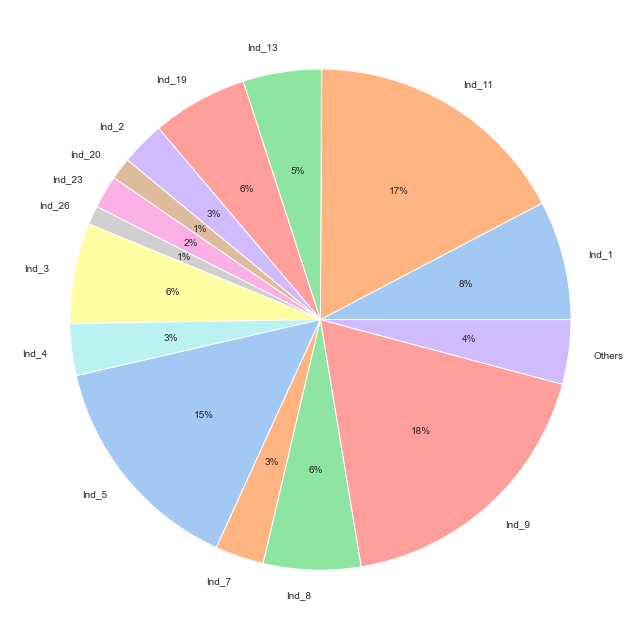

In [6]:
# plt figure
plt.figure(figsize=(30,9))

# define Seaborn color palette to use
colors = sns.color_palette('pastel', n_colors=None) #[0:26]

# create pie chart
plt.pie(percent_total_df_reduced.percent_total, labels=percent_total_df_reduced.Industry_Sub_Category_Reduced, colors=colors, autopct='%.0f%%')
plt.tight_layout()
plt.show()

---
# 2. Business Type Proportion
---

In [7]:
business_type_df = scenarios_summary_df[['Industry_Sub_Category_Reduced', 'num_total', 'num_micro', 'num_small', 'num_medium']].copy()
business_type_df.loc[:, 'micro'] = np.round(business_type_df['num_micro']/business_type_df['num_total'] * 100, 2)
business_type_df.loc[:, 'small'] = np.round(business_type_df['num_small']/business_type_df['num_total'] * 100, 2)
business_type_df.loc[:, 'medium'] = np.round(business_type_df['num_medium']/business_type_df['num_total'] * 100, 2)

business_type_df = business_type_df[['Industry_Sub_Category_Reduced', 'micro', 'small', 'medium']].groupby('Industry_Sub_Category_Reduced').mean().reset_index()
business_type_df_means = business_type_df.mean().reset_index().rename(columns={'index':'Business Type', 0:'Percentages'})

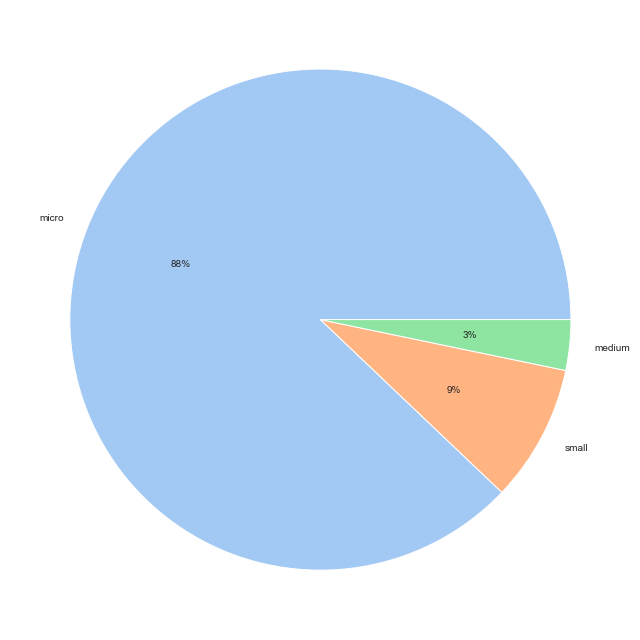

In [8]:
# plt figure
plt.figure(figsize=(30,9))

# define Seaborn color palette to use
colors = sns.color_palette('pastel', n_colors=None) #[0:26]

# create pie chart
plt.pie(business_type_df_means.Percentages, labels=business_type_df_means['Business Type'], colors=colors, autopct='%.0f%%')
plt.tight_layout()
plt.show()

---
# 3. Revenues
---

In [9]:
# select revenue columns
scenarios_summary_df[['hist_revenue_counts','hist_revenue_bins']] = scenarios_summary_df.hist_basic_revenues.tolist()
hist_bins = scenarios_summary_df.hist_revenue_bins[0]

# create empty dataframe
hist_summary_by_ind = pd.DataFrame(columns=('Industry_Sub_Category_Reduced', 'hist_revenue_counts', 'hist_revenue_bins'))

for i, cat in enumerate(order):
    hist_summary_by_ind.loc[i, 'hist_revenue_counts'] = scenarios_summary_df[scenarios_summary_df['Industry_Sub_Category_Reduced']==cat].hist_revenue_counts.sum(axis=0)
    hist_summary_by_ind.loc[i, 'hist_revenue_bins'] = range(len(hist_bins))    
    hist_summary_by_ind.loc[i, 'Industry_Sub_Category_Reduced'] = cat 

NameError: name 'order' is not defined

In [ ]:
# Across 1000 scenarios
fig, ax = plt.subplots(nrows=6, ncols=5, figsize=(30, 20))

for i, cat in enumerate(order):
    # parameters
#     x = scenarios_summary_df[(scenarios_summary_df['Industry_Sub_Category_Reduced']==cat) & (scenarios_summary_df.scenario_num==0)]['hist_adv_counts']
#     y = range(len(hist_bins)) 

    x = hist_summary_by_ind[hist_summary_by_ind['Industry_Sub_Category_Reduced']==cat]['hist_revenue_counts']
    y = hist_summary_by_ind[hist_summary_by_ind['Industry_Sub_Category_Reduced']==cat]['hist_revenue_bins']
    
    # plot histogram
    plt.subplot(6,5,i+1)
    plt.stairs(x[i], y[i], fill=True, baseline=0)
    plt.vlines(y[i], 0, x[i].max(), colors='w')

    for ii,j in zip(x[i], y[i]):
        if ii != 0:
            inplot = plt.annotate(str(ii)
                                  ,xy=(j,ii+1)
                                  ,fontsize=10
                                  ,color='red')
    
    # x- and y- labels
    plt.xlabel("Revenue Band")
    plt.ylabel("Count")
    
    # x- and y- axis limits
    plt.xlim([1, 10])
    plt.ylim([0, 15_000_000])
    
    # plot titles
    plt.title(f'{cat}')

plt.title('Revenue Distribution in Industries by Revenue bands')
plt.tight_layout()
plt.show()

---
# 4. Decline Rates & Causes
---

In [10]:
# select & rename columns on revenue, hazard grade, upguard scores
# revenue
revenue_decline_df = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_revenue_decline']].rename(columns={'percent_revenue_decline': '% Decline'})
revenue_decline_df.loc[:, 'Decline'] = 'Revenue'

# hazard grade
hazard_decline_df = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_hazard_decline']].rename(columns={'percent_hazard_decline': '% Decline'})
hazard_decline_df.loc[:, 'Decline'] = 'Hazard'

# upguard scores
upguard_decline_df = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_upguard_decline']].rename(columns={'percent_upguard_decline': '% Decline'})
upguard_decline_df.loc[:, 'Decline'] = 'Upguard'

# total declines
total_decline_df = buisness_prop[['Industry_Sub_Category_Reduced', 'percent_total_decline']].rename(columns={'percent_total_decline': '% Decline'})
total_decline_df.loc[:, 'Decline'] = 'Total'

# append all into a dataframe
declines_df = pd.concat([revenue_decline_df, hazard_decline_df, upguard_decline_df, total_decline_df])

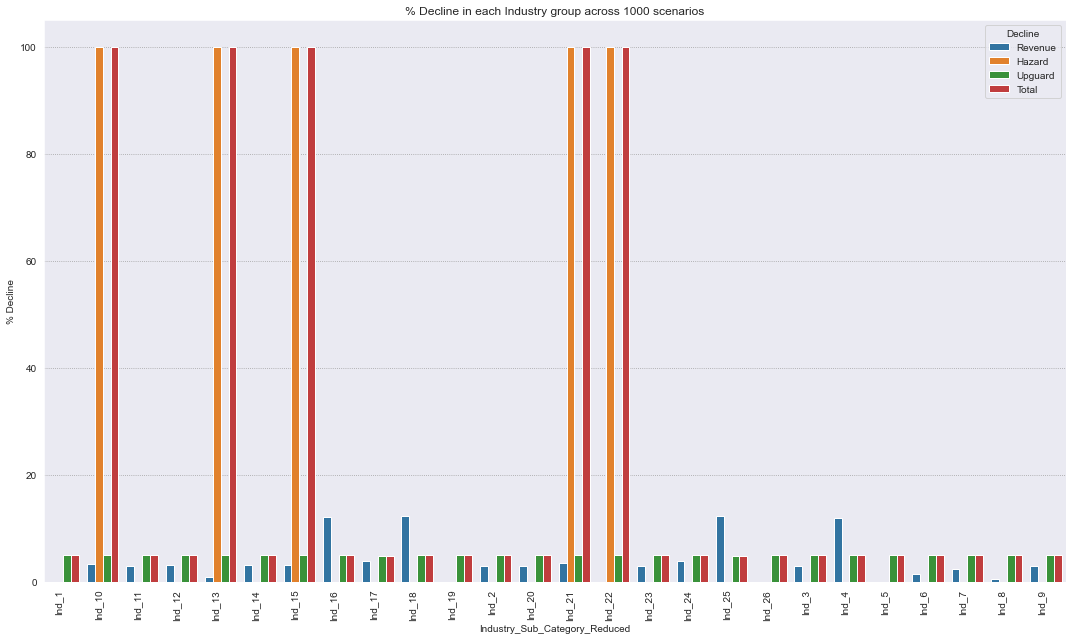

In [11]:
plt.figure(figsize=(15,9))
sns.barplot(data=declines_df, y="% Decline", x="Industry_Sub_Category_Reduced", hue="Decline")

plt.xticks(rotation = 90, ha = 'right')

plt.title(f"% Decline in each Industry group across {num_scenarios} scenarios")
plt.tight_layout()
plt.show()

---
# 5. Premiums
---
## 5.1 Mean Distribution by Coverage Plans
---
This can be seen as a measure of risk


In [12]:
# order is used in the plot below to sort the premiums from low to high
order = scenarios_summary_df[scenarios_summary_df.scenario_num==0][['Industry_Sub_Category_Reduced', 'mean_adv_prem']].sort_values('mean_adv_prem').Industry_Sub_Category_Reduced.to_list()

In [13]:
# 1. Mean Premiums
basic_prems_df = scenarios_summary_df[['Industry_Sub_Category_Reduced', 'mean_basic_prem']].rename(columns={'mean_basic_prem': 'Mean Premiums'})
basic_prems_df.loc[:, 'Coverage Plan'] = 'Basic'

std_prems_df = scenarios_summary_df[['Industry_Sub_Category_Reduced', 'mean_stand_prem']].rename(columns={'mean_stand_prem': 'Mean Premiums'})
std_prems_df.loc[:, 'Coverage Plan'] = 'Stand'

adv_prems_df = scenarios_summary_df[['Industry_Sub_Category_Reduced', 'mean_adv_prem']].rename(columns={'mean_adv_prem': 'Mean Premiums'})
adv_prems_df.loc[:, 'Coverage Plan'] = 'Advanced'

mean_prem_df = pd.concat([basic_prems_df, std_prems_df, adv_prems_df])

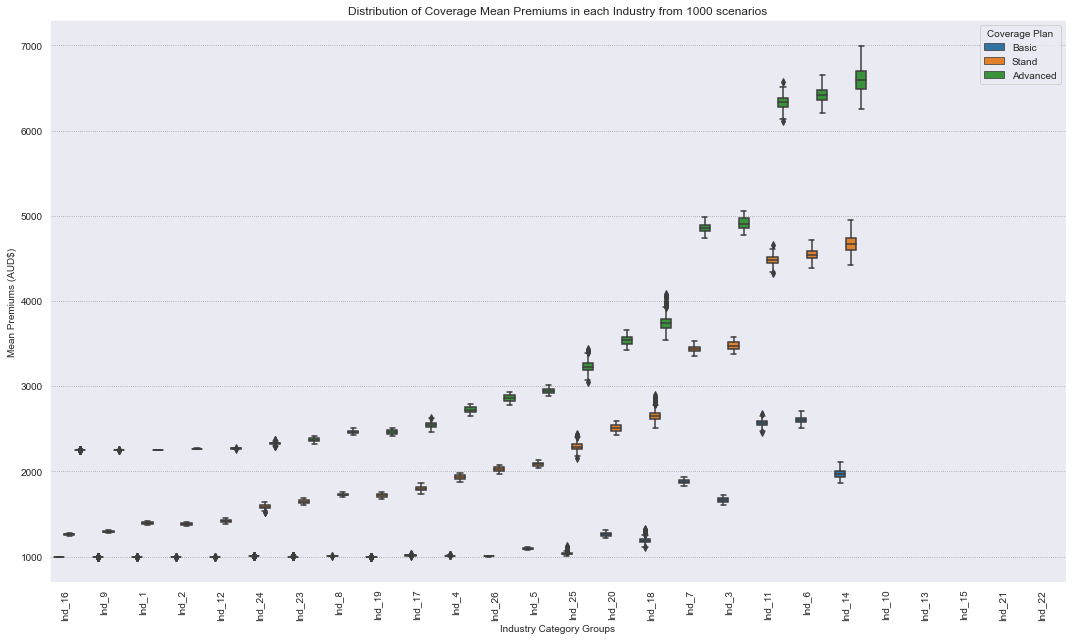

In [14]:
plt.figure(figsize=(15,9))
ax = sns.boxplot(data=mean_prem_df, x='Industry_Sub_Category_Reduced', y='Mean Premiums', hue='Coverage Plan', order=order)
    
# plot labels
plt.xlabel("Industry Category Groups")
plt.ylabel("Mean Premiums (AUD$)")

plt.xticks(rotation = 90, ha = 'right')
plt.title(f"Distribution of Coverage Mean Premiums in each Industry from {num_scenarios} scenarios")
plt.tight_layout()
plt.show(ax)

---
# 6. Total Market Coverage
---
## 6.1 Sum total premiums  
---


In [15]:
total_market_coverage_df = scenarios_summary_df[['scenario_num','Industry_Sub_Category_Reduced','num_total','num_total_decline','sum_basic_prem', 'sum_std_prem', 'sum_adv_prem']]

In [16]:
# 1. Total Market Coverage Premiums
basic_total_prems_df = scenarios_summary_df[['scenario_num','Industry_Sub_Category_Reduced', 'sum_basic_prem']].rename(columns={'sum_basic_prem': 'Total Premiums'})
basic_total_prems_df.loc[:, 'Coverage Plan'] = 'Basic'

std_total_prems_df = scenarios_summary_df[['scenario_num', 'Industry_Sub_Category_Reduced', 'sum_std_prem']].rename(columns={'sum_std_prem': 'Total Premiums'})
std_total_prems_df.loc[:, 'Coverage Plan'] = 'Standard'

adv_total_prems_df = scenarios_summary_df[['scenario_num', 'Industry_Sub_Category_Reduced', 'sum_adv_prem']].rename(columns={'sum_adv_prem': 'Total Premiums'})
adv_total_prems_df.loc[:, 'Coverage Plan'] = 'Advanced'

total_market_coverage_df = pd.concat([basic_total_prems_df, std_total_prems_df, adv_total_prems_df])

In [17]:
hist_bins = list(range(5_000_000, 20_000_000, 100_000))

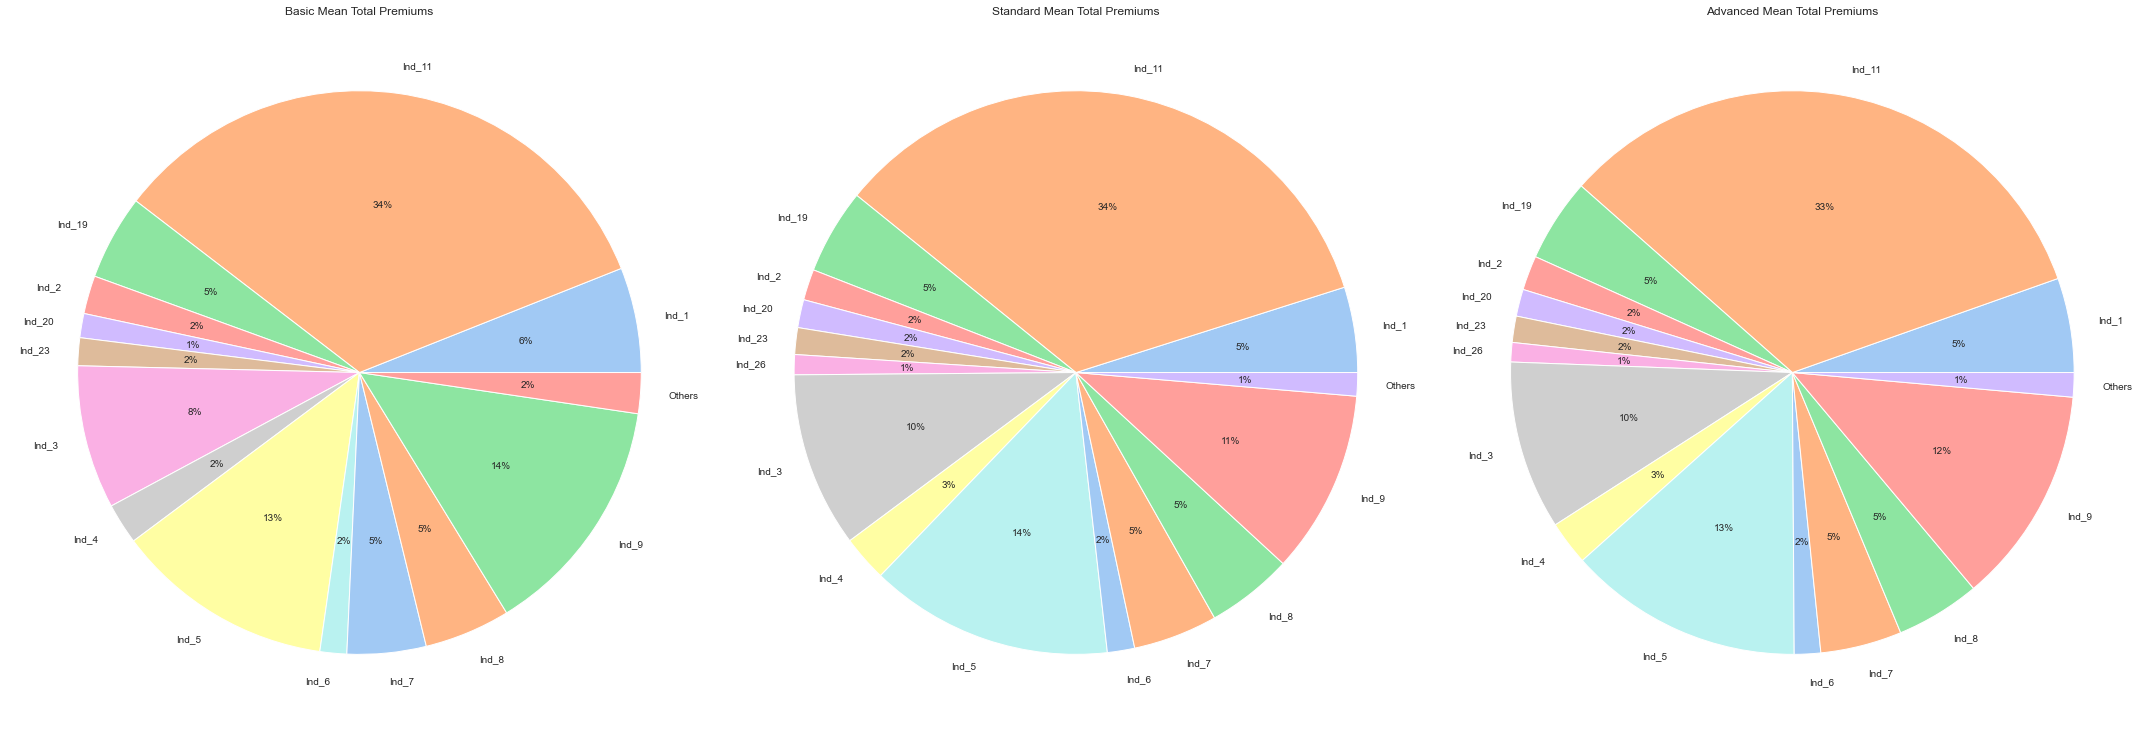

In [18]:
# pie charts
reduced_total_market_coverage_df = total_market_coverage_df.groupby(['Industry_Sub_Category_Reduced', 'Coverage Plan']).mean().reset_index()
coverage_plan_cats = ['Basic', 'Standard', 'Advanced']

# plt figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))

# define Seaborn color palette to use
colors = sns.color_palette('pastel', n_colors=None) #[0:26]

for i, cat in enumerate(coverage_plan_cats):
    
    tmp = reduced_total_market_coverage_df[reduced_total_market_coverage_df['Coverage Plan']==cat].copy()
    tmp['% Total Premiums'] = np.round(tmp['Total Premiums']/tmp['Total Premiums'].sum()*100, 2)

    tmp_highs = tmp[tmp['% Total Premiums'] > 1].reset_index() 

    tmp_lows = pd.DataFrame(columns=('Industry_Sub_Category_Reduced', 'Coverage Plan', 'Total Premiums', '% Total Premiums'))
    tmp_lows.loc[0,'% Total Premiums'] = tmp[tmp['% Total Premiums'] <= 1]['% Total Premiums'].sum()
    tmp_lows.loc[0,'Total Premiums'] = tmp[tmp['% Total Premiums'] <= 1]['Total Premiums'].sum()
    tmp_lows.loc[0,'Coverage Plan'] = cat
    tmp_lows.loc[0,'Industry_Sub_Category_Reduced'] = 'Others'
    tmp_reduced = pd.concat([tmp_highs, tmp_lows])

    # create pie chart
    plt.subplot(1, 3, i+1)
    plt.pie(tmp_reduced['Total Premiums'], labels=tmp_reduced.Industry_Sub_Category_Reduced, colors=colors, autopct='%.0f%%')
    plt.title(f'{cat} Mean Total Premiums')
    
plt.tight_layout()
plt.show()

---
# 6.2 Total Premiums Distribution
---

In [19]:
# order is used in the plot below to sort the premiums from low to high
order_total_premiums = total_market_coverage_df[(total_market_coverage_df.scenario_num==0) & (total_market_coverage_df['Coverage Plan']=='Standard')][['Industry_Sub_Category_Reduced', 'Total Premiums']].sort_values('Total Premiums').Industry_Sub_Category_Reduced.to_list()

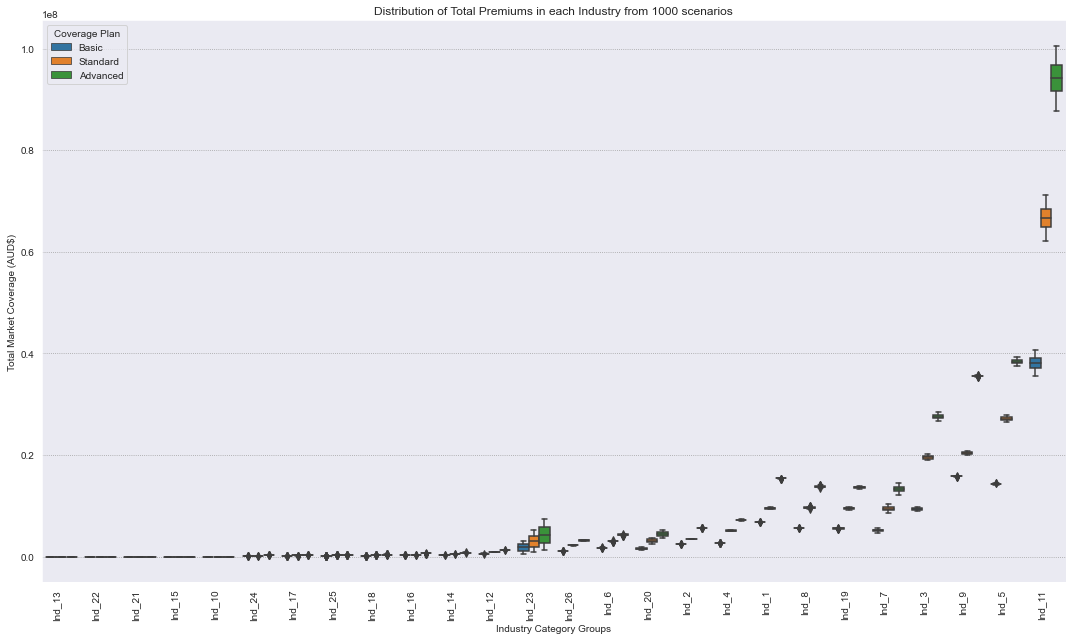

In [20]:
plt.figure(figsize=(15,9))
ax = sns.boxplot(data=total_market_coverage_df, x='Industry_Sub_Category_Reduced', y='Total Premiums', hue='Coverage Plan', order=order_total_premiums)

# plot labels
plt.xlabel("Industry Category Groups")
plt.ylabel("Total Market Coverage (AUD$)")

plt.xticks(rotation = 90, ha = 'right')
plt.title(f"Distribution of Total Premiums in each Industry from {num_scenarios} scenarios")
plt.tight_layout()
plt.show(ax)

---
# 7. Industries to Target
---

In [21]:
# risk matrix which is given by the mean advanded premiums
risk_matrix = pd.DataFrame(order).rename(columns={0: 'Industry_Sub_Category_Reduced'})
risk_matrix['Risk_level'] = list(range(len(risk_matrix)))


# proportion matrix is given by total sum advanced premiums
proportion_matrix = pd.DataFrame(order_total_premiums).rename(columns={0: 'Industry_Sub_Category_Reduced'})
proportion_matrix['Proportion_level'] = list(range(len(proportion_matrix)))

# 
percent_total_df = total_market_coverage_df[(total_market_coverage_df.scenario_num==0) & (total_market_coverage_df['Coverage Plan']=='Standard')][['Industry_Sub_Category_Reduced', 'Total Premiums']].sort_values('Total Premiums')
percent_total_df['Percentage Coverage Total'] = np.round(percent_total_df['Total Premiums']/sum(percent_total_df['Total Premiums'])*100,2)

advanced_premiums_df = scenarios_summary_df[scenarios_summary_df.scenario_num==0][['Industry_Sub_Category_Reduced', 'mean_stand_prem']].sort_values('mean_stand_prem')

In [22]:
risk_prop_matrix = proportion_matrix.merge(risk_matrix, on='Industry_Sub_Category_Reduced')
risk_prop_matrix = risk_prop_matrix.merge(percent_total_df[['Industry_Sub_Category_Reduced', 'Percentage Coverage Total']], on='Industry_Sub_Category_Reduced')
risk_prop_matrix = risk_prop_matrix.merge(advanced_premiums_df, on='Industry_Sub_Category_Reduced')
risk_prop_matrix = risk_prop_matrix.dropna()

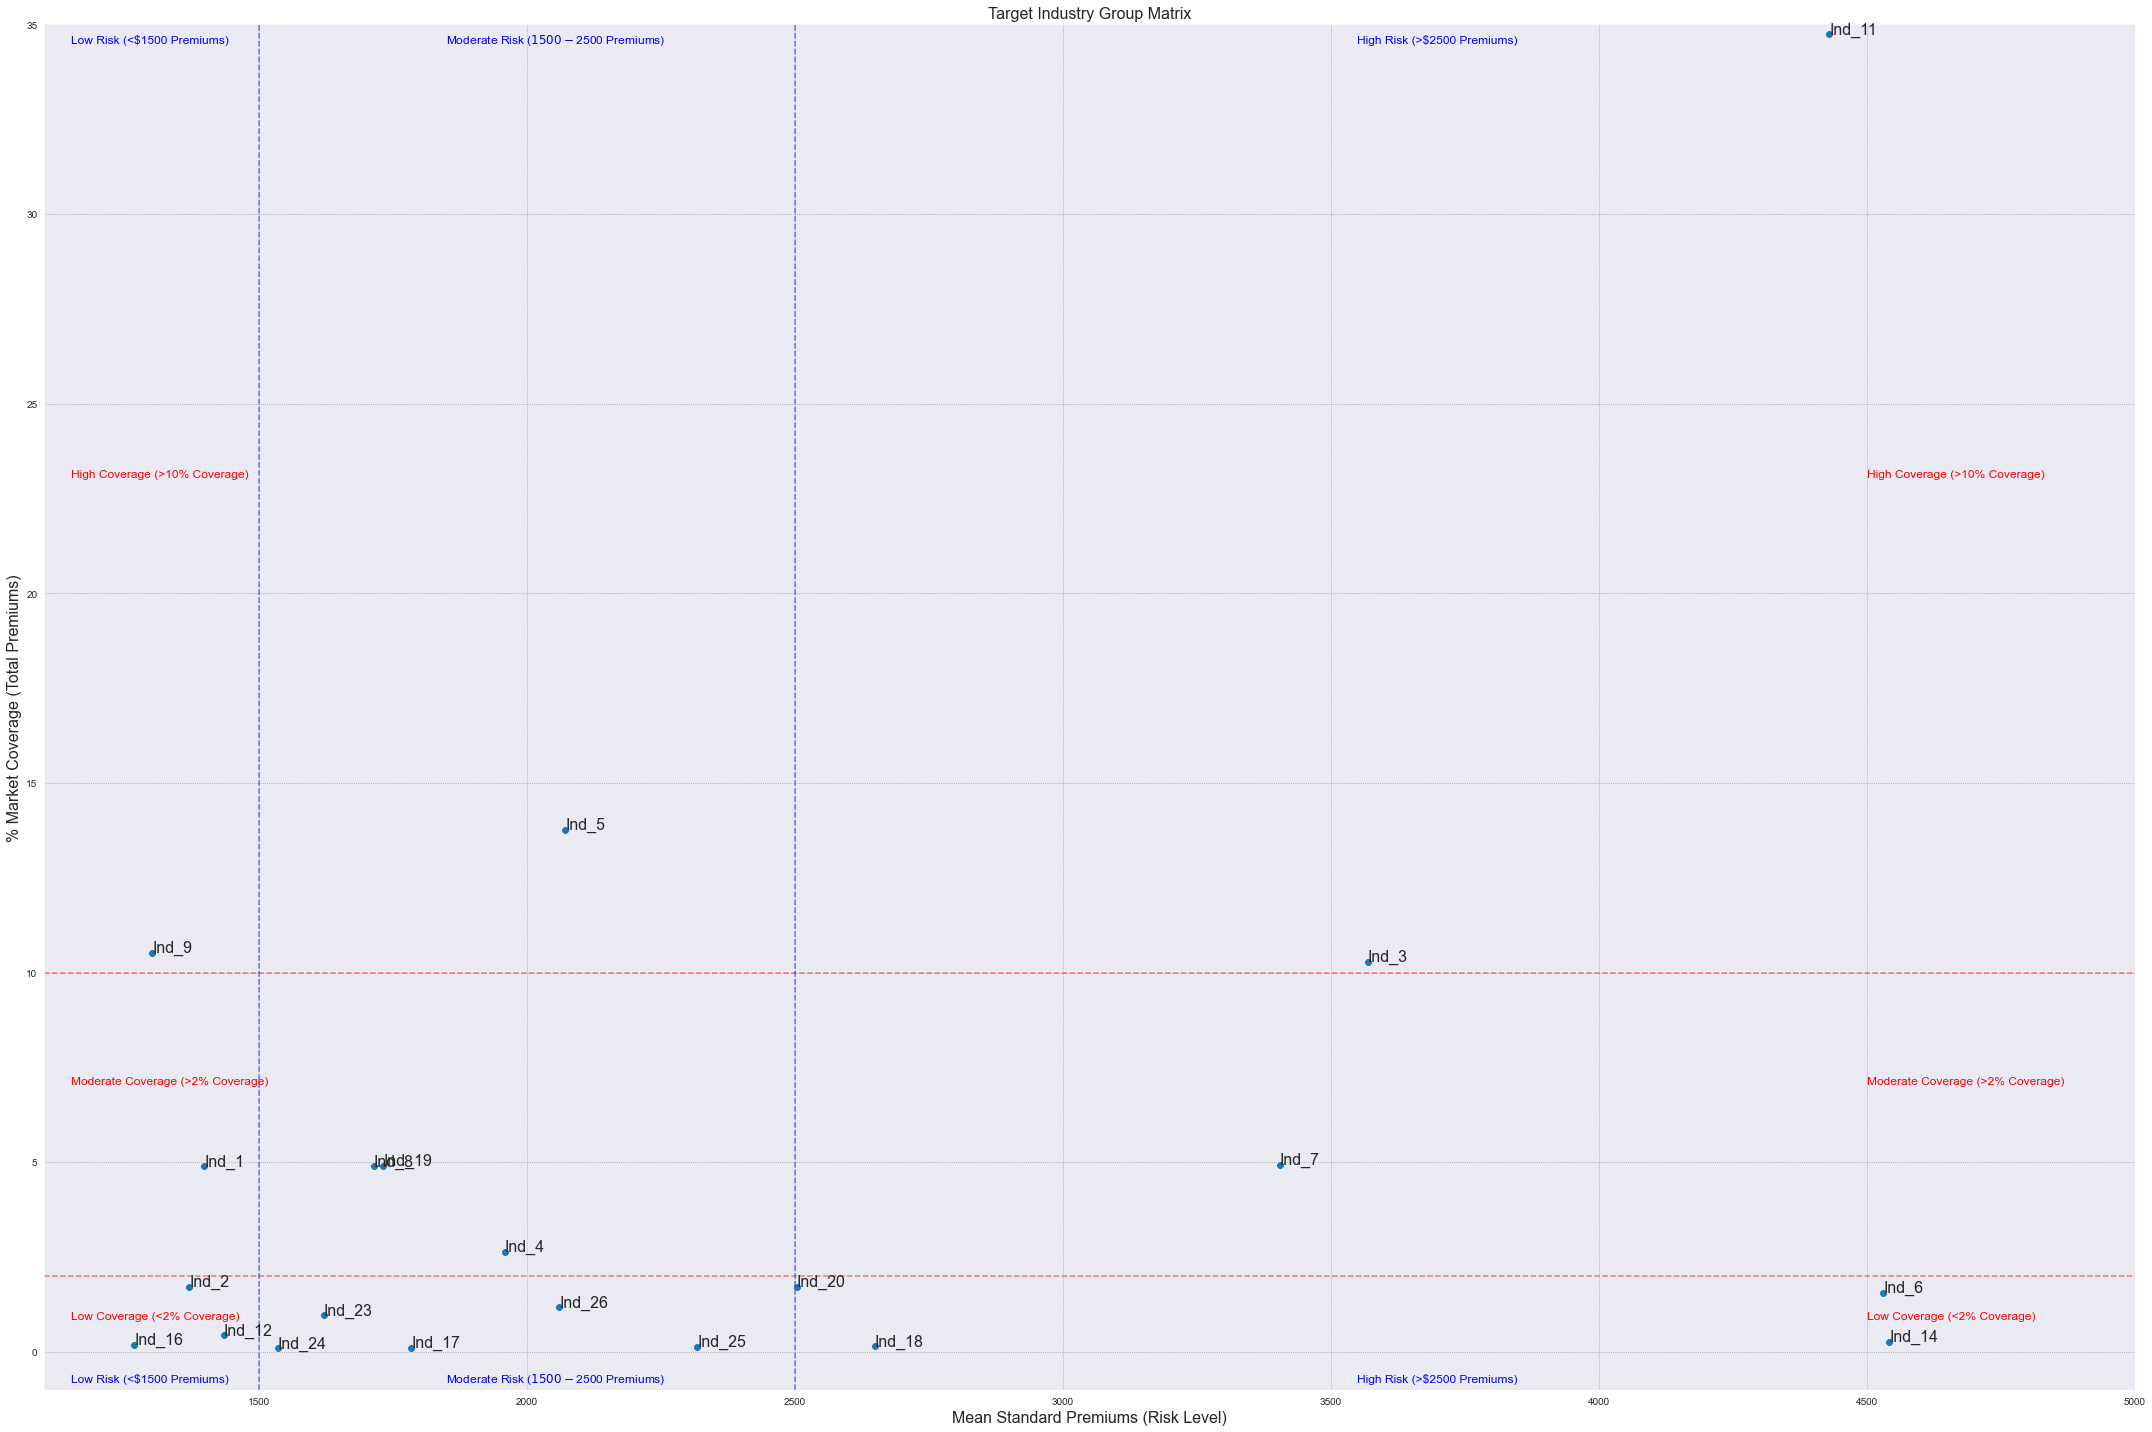

In [23]:
def plotlabel(xvar, yvar, label):
    ax.text(xvar+0.02, yvar+0.02, label, fontsize=16)

fig = plt.figure(figsize=(30,20))

yvar = 'Percentage Coverage Total'  # 'Proportion_level'
ax = sns.scatterplot(y=yvar, x='mean_stand_prem', data=risk_prop_matrix[risk_prop_matrix[yvar]>0], s=60, legend=False) #, aspect=2)

# The magic starts here:
risk_prop_matrix[risk_prop_matrix.Proportion_level>0].apply(lambda x: plotlabel(x['mean_stand_prem'], x[yvar], x['Industry_Sub_Category_Reduced']), axis=1)

# add horizontal lines
ax.axhline(10, 0, 1, color='r', linestyle='--', alpha=0.5)
ax.axhline(2, 0, 1, color='r', linestyle='--', alpha=0.5)

ax.text(1150+0.02, 23+0.06, 'High Coverage (>10% Coverage)', fontsize=12, color='r')
ax.text(1150+0.02, 7+0.06, 'Moderate Coverage (>2% Coverage)', fontsize=12, color='r')
ax.text(1150+0.02, 0.8+0.06, 'Low Coverage (<2% Coverage)', fontsize=12, color='r')

ax.text(4500+0.02, 23+0.06, 'High Coverage (>10% Coverage)', fontsize=12, color='r')
ax.text(4500+0.02, 7+0.06, 'Moderate Coverage (>2% Coverage)', fontsize=12, color='r')
ax.text(4500+0.02, 0.8+0.06, 'Low Coverage (<2% Coverage)', fontsize=12, color='r')

# add vertical lines
ax.axvline(1500, 0, 1, color='b', linestyle='--', alpha=0.5)
ax.axvline(2500, 0, 1, color='b', linestyle='--', alpha=0.5)

ax.text(1150, 35-0.5, 'Low Risk (<$1500 Premiums)', fontsize=12, color='b')
ax.text(1850, 35-0.5, 'Moderate Risk ($1500-$2500 Premiums)', fontsize=12, color='b')
ax.text(3550, 35-0.5, 'High Risk (>$2500 Premiums)', fontsize=12, color='b')

ax.text(1150, -0.8, 'Low Risk (<$1500 Premiums)', fontsize=12, color='b')
ax.text(1850, -0.8, 'Moderate Risk ($1500-$2500 Premiums)', fontsize=12, color='b')
ax.text(3550, -0.8, 'High Risk (>$2500 Premiums)', fontsize=12, color='b')

plt.title('Target Industry Group Matrix', size=16)
plt.xlim([1100,5000])
plt.ylim([-1,35])
plt.xlabel('Mean Standard Premiums (Risk Level)', size=16)
plt.ylabel('% Market Coverage (Total Premiums)', size=16)
plt.tight_layout()
plt.show()